# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
#from collections import Counter
#from sklearn.metrics import silhouette_samples, silhouette_score, mean_squared_error

# magic word for producing visualizations in notebook
%matplotlib inline

# define some helper functions below.

# imputation function replace the NaNs in selected column by its most frequent value

def impute_na(df, variable):
    '''
    input: 
            df: input dataframe to be imputed
            variable: the column from the dataframe you want to perform imputation
    '''
    # find most frequent category
    most_frequent_category = df.groupby([variable])[variable].count().sort_values(ascending=False).index[0]
    # replace NA
    df[variable].fillna(most_frequent_category, inplace=True)

    
def sanity_check(df):
    print("\n Sanity Check: The dimension of the dataset is: {}".format(df.shape))
    dtype_count = 0
    for i, col in enumerate(df.columns):
        # check if the columns are numeric type
        if (is_numeric_dtype(df[col]) is False):
            print("Warning: column index {}, column name {} is not numeric dtype!".format(i, col))
            dtype_count += 1
        # check if each column contains missing values
    nan_cols = df.columns[df.isnull().any()].tolist()
    nan_count = len(nan_cols)
    if nan_count > 0:
        print("Warning: the following columns contain missing values: \n {}".format(nan_cols))
    print("There are {} columns of non-numeric dtype.".format(dtype_count))
    print("There are {} columns containing missing values.".format(nan_count))
    
# re-engineer helper function

def feature_decade(x):
    '''
    input: integer
    return: 1 stands for 40s, 2 for 50s, 3 for 60s, 4 for 70s, 5 for 80s and 6 for 90s
    '''
    if x >= 1 and x <= 2:
        return 1
    elif x >= 3 and x <= 4:
        return 2
    elif x >= 5 and x <= 7:
        return 3
    elif x >= 8 and x <= 9:
        return 4
    elif x >= 10 and x <= 13:
        return 5
    elif x >= 14 and x <= 15:
        return 6
    else:
        return np.nan

# re-engineer helper function

def feature_movement(x):
    '''
    input: integer
    return: 0 for mainstream, and 1 for avantgarde
    '''
    if x in set([1, 3, 5, 8, 10, 12, 14]):
        return 0
    elif x in set([2, 4, 6, 7, 9, 11, 13, 15]):
        return 1
    else:
        return np.nan

def feature_neighborhood(x):
    '''
    1-5 = 1-5, 7 and 8 are mapped to np.nan
    '''
    if x <= 5:
        return x
    else:
        return np.nan

def feature_rural(x):
    '''
    1-5 = not rural, return as 0
    7-8 = rural, return as 1
    '''
    if x <= 5:
        return 0
    elif (x == 7) | (x == 8):
        return 1
    else:
        return np.nan
    
def feature_homes(x):
    '''
    1-4 return as 1-4 (homes)
    5 return as np.nan 
    '''
    if x <= 4:
        return x
    else:
        return np.nan

def feature_business(x):
    '''
    1-4 return 0 (non-business)
    5 return 1(business)
    '''
    if x <= 4:
        return 0
    elif x == 5:
        return 1
    else:
        return np.nan

# count plots
def count_plot(data, features, hue, normalized = False):
    nrow = 3
    ncol = int(len(features)/3)
    fig = plt.figure(figsize = (20, 20))
    if normalized is False:
        for i in np.arange(len(features)):
            ax = fig.add_subplot(ncol, nrow, i+1)
            ax = sns.countplot(x = features[i], hue = hue, data = data, ax = ax)
    else:
        for i in np.arange(len(features)): 
            ax = fig.add_subplot(ncol, nrow, i+1)
            data_ = (data.groupby([hue])[features[i]]
                             .value_counts(normalize=True)
                             .rename('percentage')
                             .mul(100)
                             .reset_index()
                             .sort_values(features[i]))
            ax = sns.barplot(x=features[i], y="percentage", hue=hue, data=data_, ax = ax)
    return ax

def scree_plot(pca, var_thres = 90):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
           var_thres - percent explained variance threshold
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    idx = np.arange(num_components)
    vals = pca.explained_variance_ratio_ * 100
    cumvals = np.cumsum(vals)
    # index of component where the culmulative sum of variance reaches the threshold
    plt_idx = np.argmin(np.abs(var_thres - cumvals))
    print("Cut point of {}% explained variance is at the {}-th component".format(var_thres,plt_idx+1))
    
    fig = plt.figure(figsize = (12, 15))
    
    # plot explained variance
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.bar(idx, vals)
    ax1.grid()
    y_vline = [np.min(vals), np.max(vals)]
    x_vline = np.ones(len(y_vline))*plt_idx
    plt.plot(x_vline, y_vline, 'r--')
      
    # plot culmulative explained variance
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.bar(idx, cumvals)
    ax2.grid()
    # threshold horizontal line
    h_line = np.ones(len(idx))*var_thres
    # threshold vertical line
    y_vline = [0, 100]
    x_vline = np.ones(len(y_vline))*plt_idx
    plt.plot(idx, h_line, 'r--')
    plt.plot(x_vline, y_vline, 'r--')
       
    # plot setting 
    ax1.xaxis.set_tick_params(width=0)
    ax1.yaxis.set_tick_params(width=2, length=12)
    ax1.set_xlim(0, len(idx))
    ax1.set_ylim(np.min(vals), np.max(vals))
    ax1.set_xlabel("Principal Component", fontsize = 12)
    ax1.set_ylabel("Explained Variance (%)", fontsize = 12)
    ax1.set_title('Explained Variance Per Principal Component', fontsize = 12)
    ax2.xaxis.set_tick_params(width=0)
    ax2.yaxis.set_tick_params(width=2, length=12)
    ax2.set_xlim(0, len(idx))
    ax2.set_ylim(0, 100)
    ax2.set_xlabel("Principal Component", fontsize = 12)
    ax2.set_ylabel("Cumulative Explained Variance (%)", fontsize = 12)
    ax2.set_title('Culmulative Explained Variance vs. Number of Component', fontsize = 12)
    
def pca_weight_decomp(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained_Variance_Ratio'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

def show_pca_weight(df, topk_components = 3, topk_features = 10, kth_component = None, figsize = (16, 16), plot = True, print_screen = False):
    variance_ratios = df['Explained_Variance_Ratio']
    components = df.drop('Explained_Variance_Ratio', axis = 1)
    dimensions = df.index
    components_T = components.T
    features = components_T.index
    result = []
    #if plot:
    #    fig = plt.figure(figsize = figsize)
    # Plot the feature weights as a function of the components
    for i, column in enumerate(components_T.columns):
        if i < topk_components:    
            feature_weights = components_T[column].values 
            idx = np.argsort(-np.abs(feature_weights))
            feature_weights = feature_weights[idx][0:topk_features]
            feature_names = features[idx][0:topk_features]
            for j, (feature_name, feature_weight) in enumerate(zip(feature_names, feature_weights)):
                result.append([column, feature_name, feature_weight])
                if print_screen:
                    print("{}: feature: {} weight: {}".format(column, feature_name, feature_weight))
            
            my_colors = [(x/len(feature_weights)/2, x/len(feature_weights), 0.75) \
                         for x in range(len(feature_weights))]
            y_pos = np.arange(len(feature_names))
            if plot:
                fig = plt.figure(figsize = figsize)
                if kth_component is None:
                    ax = fig.add_subplot(topk_components, 1, i+1)
                    plt.barh(y_pos, feature_weights[::-1], color = my_colors)
                    plt.yticks(y_pos, feature_names[::-1])
                    ax.set_title(column, fontsize = 20)
                    ax.grid()
                elif i == kth_component - 1:
                    ax = fig.add_subplot(1, 1, 1)
                    plt.barh(y_pos, feature_weights[::-1], color = my_colors)
                    plt.yticks(y_pos, feature_names[::-1])
                    ax.set_title(column, fontsize = 20)
                    ax.grid()
    df = pd.DataFrame(result)
    df.columns = ['Dimension', 'feature', 'PCA_Weight']
    if kth_component is not None:
        df = df[df['Dimension'] == 'Dimension ' + str(int(kth_component))]
    return df


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
nrow = azdias.shape[0]
ncol = azdias.shape[1]
print('The number of rows and columns: {} x {} in demographics data'.format(nrow, ncol))
azdias.head()

The number of rows and columns: 891221 x 85 in demographics data


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
print('The number of rows and columns: {} x {} in summary file'.format(feat_info.shape[0], feat_info.shape[1]))
feat_info.head()

The number of rows and columns: 85 x 4 in summary file


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Step1: For feat_info, convert missing_or_unknown into lists of NaN: '[-1,0]' -> [-1, 0] and '[-1,XX]' -> [-1, 'XX']
X = 'X'
XX = 'XX'
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: eval(x))
feat_info.head()

#for i, vals in enumerate(feat_info['missing_or_unknown']):
#    azdias.iloc[:, i] = azdias.iloc[:, i].astype(str).replace(vals, np.nan)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
# Step2: For azdias, replace codes in each column indicating missing or unknown data with NaN values
for y in azdias.columns:
    # locate the list in the feat_info correponding to the column in azdias, and save as a set of NaN codes
    NaN_set = set(feat_info[feat_info['attribute']==y].iloc[0,3])
    
    # uncomment below to print details
    print('Converting missing values {} to np.nan in data column: {}'.format(NaN_set,y))
    
    # replace all NaN codes by NaN values
    #azdias[y] = azdias[y].apply(lambda x: replaceNa(x, NaN_set))
    azdias[y] = azdias[y].apply(lambda x: np.nan if x in NaN_set else x)

Converting missing values {0, -1} to np.nan in data column: AGER_TYP
Converting missing values {0, 9, -1} to np.nan in data column: ALTERSKATEGORIE_GROB
Converting missing values {0, -1} to np.nan in data column: ANREDE_KZ
Converting missing values {0} to np.nan in data column: CJT_GESAMTTYP
Converting missing values {-1} to np.nan in data column: FINANZ_MINIMALIST
Converting missing values {-1} to np.nan in data column: FINANZ_SPARER
Converting missing values {-1} to np.nan in data column: FINANZ_VORSORGER
Converting missing values {-1} to np.nan in data column: FINANZ_ANLEGER
Converting missing values {-1} to np.nan in data column: FINANZ_UNAUFFAELLIGER
Converting missing values {-1} to np.nan in data column: FINANZ_HAUSBAUER
Converting missing values {-1} to np.nan in data column: FINANZTYP
Converting missing values {0} to np.nan in data column: GEBURTSJAHR
Converting missing values set() to np.nan in data column: GFK_URLAUBERTYP
Converting missing values set() to np.nan in data col

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

ls = []
# calculate percentage of NaN in each data column
for i, column in enumerate(azdias.columns):
    count = azdias[column].isnull().sum(axis=0)
    percent = count/azdias.shape[0]
    ls.append([column, count, percent*100])
# store into summary table, sorted by percentage
azdias_summary = pd.DataFrame.from_records(ls, columns = ['Feature', 'NaN Count', 'NaN Occupancy Rate'])
azdias_summary = azdias_summary.sort_values('NaN Occupancy Rate',axis=0,ascending = False)

In [8]:
# explore top 15 features 
azdias_summary.head(15)

,Feature,NaN Count,NaN Occupancy Rate
40,TITEL_KZ,889061,99.757636
0,AGER_TYP,685843,76.955435
47,KK_KUNDENTYP,584612,65.596749
64,KBA05_BAUMAX,476524,53.468668
11,GEBURTSJAHR,392318,44.020282
43,ALTER_HH,310267,34.813699
70,KKK,158064,17.735668
73,REGIOTYP,158064,17.735668
48,W_KEIT_KIND_HH,147988,16.605084
60,KBA05_ANTG1,133324,14.959701


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74fa70a5f8>]], dtype=object)

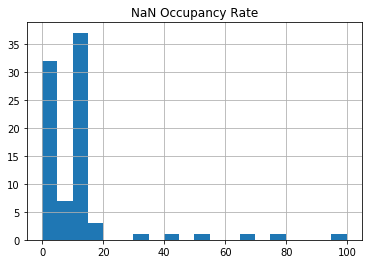

In [9]:
# visualize the distribution of missing value counts to find these columns
azdias_summary.hist(column='NaN Occupancy Rate', bins = 20)

<p> The histogram above shows that most features are condensed within the 0%~20% bin. We can roughly consider those above 40% as outliers. Below shows more details about these outliers. </p>

In [10]:
# Identify outliers (say above 30% is considered as outliers) from the histogram and document these features
thres = 30
feature_to_drop = azdias_summary[azdias_summary['NaN Occupancy Rate'] > thres]
display(feature_to_drop)

,Feature,NaN Count,NaN Occupancy Rate
40,TITEL_KZ,889061,99.757636
0,AGER_TYP,685843,76.955435
47,KK_KUNDENTYP,584612,65.596749
64,KBA05_BAUMAX,476524,53.468668
11,GEBURTSJAHR,392318,44.020282
43,ALTER_HH,310267,34.813699


<p> In the next step, we can explore among the remaining features to find whether multiple features share NaNs simultaneously. To do that, we can sum up the count of NaNs in each data row. And only explore those rows having some large number of total NaNs, say n > 30. </p>

In [11]:
# Investigate patterns in the amount of missing data in each column.
azdias_drop_NaN = azdias.drop(feature_to_drop.Feature, axis=1)
azdias_subset = azdias_drop_NaN.isnull().astype(int) 
azdias_subset = azdias_subset[azdias_subset.sum(axis = 1) > 30]
azdias_subset.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
11,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
14,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
17,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
24,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


<p> The table above shows that for some features that belong to the same sub-category (with similar prefix), such as PLZ8_ANTG1, PLZ8_ANTG2 ... etc, it is very likely they share the missing data. The values of ones in these buckets indicate they are NaNs. This makes sense because in many scenarios,there is no such information for these people (in this case, number of family houses in the PLZ8 region). </p>

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

#### Answer:
To recap, we find that about 6 features with NaN occupancy rate above 30%. In descending order, they are: <strong>TITEL_KZ</strong> (99%), <strong>AGER_TYP</strong> (77%), <strong>KK_KUNDENTYP</strong> (66%), <strong>KBA05_BAUMAX</strong> (54%), <strong>GEBURTSJAHR</strong> (44%), <strong>ALTER_HH</strong> (35%). They can be identified as outliers as clearly shown by the histogram distribution. In further data processing, we can just simply rule out these features. The rest of features are heavily weighted in the 0~20% bucket, part of which share very similar pattern: all sub-features that belong to the same category can have the missing data simultaneously. This occurs when there is no information available for this category.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?
ncol = azdias_drop_NaN.shape[1]
azdias_drop_NaN['NaN Count'] = azdias_drop_NaN.isnull().sum(axis=1)
azdias_drop_NaN['NaN Occupancy Rate'] = azdias_drop_NaN['NaN Count'].apply(lambda x: x/ncol*100)
azdias_drop_NaN['label'] = azdias_drop_NaN['NaN Occupancy Rate'].apply(lambda x: '%NaN Below '+str(int(thres)) \
        if x <= thres else '%NaN Above '+str(int(thres)))
azdias_drop_NaN[['NaN Count', 'NaN Occupancy Rate', 'label']].sort_values( \
        'NaN Occupancy Rate',axis=0,ascending = False).head()

,NaN Count,NaN Occupancy Rate,label
732775,49,62.025316,%NaN Above 30
643174,49,62.025316,%NaN Above 30
472919,48,60.759494,%NaN Above 30
345274,47,59.493671,%NaN Above 30
299868,47,59.493671,%NaN Above 30


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74eefa8748>]], dtype=object)

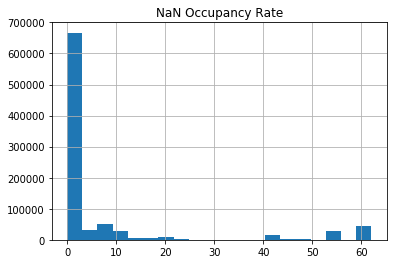

In [13]:
# plot the histogram
azdias_drop_NaN.hist(column='NaN Occupancy Rate', bins = 20)

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

idx = azdias_drop_NaN['NaN Occupancy Rate'] > thres
outlier_CNT = azdias_drop_NaN[idx].shape[0]
outlier_PCT = outlier_CNT/azdias_drop_NaN.shape[0]*100
print('The total count of data above NaNs {}% threshold is {}, which consist of {}% of data set'.format(thres, outlier_CNT, outlier_PCT))

The total count of data above NaNs 30% threshold is 93384, which consist of 10.478209108627377% of data set


In [15]:
# Store the row data with the number of missing values below the threshold. 
# Keep in mind that the last column 'label' should be dropped out.
# We will use this data subset in the following analysis.
azdias_small_NaN = azdias_drop_NaN[~idx].drop(['NaN Count', 'NaN Occupancy Rate', 'label'], axis = 1).reset_index(drop=True)
print('The number of rows and columns in the new dataset are:', azdias_small_NaN.shape)
display(azdias_small_NaN.head())

The number of rows and columns in the new dataset are: (797837, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
1,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
2,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
3,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
4,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Explore features with the least NaN occupancy percentage. We can pick 5 of them to make count plots.
azdias_summary.sort_values('NaN Occupancy Rate',axis=0,ascending = True).head()


,Feature,NaN Count,NaN Occupancy Rate
42,ZABEOTYP,0,0.0
8,FINANZ_UNAUFFAELLIGER,0,0.0
10,FINANZTYP,0,0.0
13,GREEN_AVANTGARDE,0,0.0
5,FINANZ_SPARER,0,0.0


In [17]:
# seleted features with no missing value or low NaN occupancy rate
selected_features = ['ZABEOTYP', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_SPARER', 'ANREDE_KZ', 'SEMIO_KAEM', \
     'ALTERSKATEGORIE_GROB', 'ONLINE_AFFINITAET', 'SEMIO_MAT', 'SEMIO_REL',\
    'CAMEO_INTL_2015', 'ORTSGR_KLS9', 'NATIONALITAET_KZ']

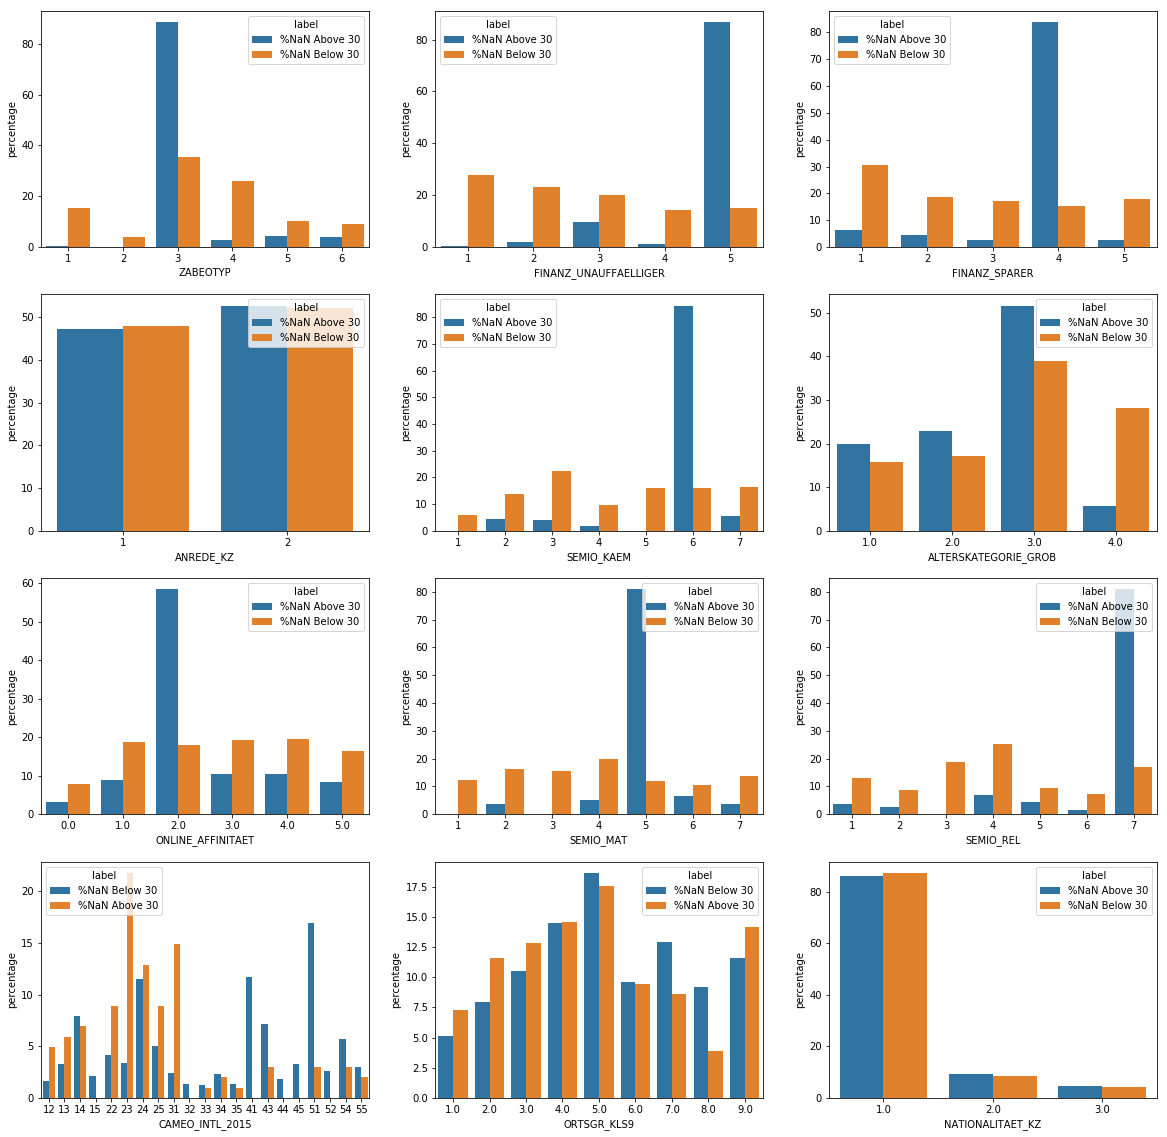

In [18]:
# plot the distribution of data below and above the threshold for each selected feature
count_plot(azdias_drop_NaN, selected_features, 'label', normalized = True)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

<strong>Answer</strong>: The histogram distribution (the first plot in Step 1.1.3) shows that most data peaks around 0% missing values, and decays quickly. Only a few outliers lies in the 30% buckets and above. Therefore, we can use 30% as a threshold to separate these outliers from the normal data.

Although these outliers only consist of 10% of the total population, we should pay attention because their distributions in some features are quite different from the majority group (below the threshold), as shown by the count plot in the second plot above. In some features, such as <strong>ANREDE_KZ</strong> (associated with the gender), <strong>NATIONALITAET_KZ</strong> (associated with the originality), the distribution of the two groups are very similar to each other. However, many features show quite different distribution: the outlier spike in "7" buckets in <strong>SEMIO_REL</strong> (associated with personality), and "5" in <strong>FINANZ_UNAUFFAELLIGER</strong> (associated with financial typology). Therefore, the statistics suggest treat these two populations are quite distinct from each other. In the following analysis, we will flag the data with row missing values above the threshold, and only focus on studying the majority group with few or no missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?
display('Number of features in each data type:', feat_info[['attribute', 'type']].groupby(['type']).count())

'Number of features in each data type:'

,attribute
type,
categorical,21
interval,1
mixed,7
numeric,7
ordinal,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
# explore all categorical features
categorical_feat = feat_info[feat_info['type'] == 'categorical']
display(categorical_feat)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [21]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# full categorical features from the data dictionary
categorical_feat_list = categorical_feat['attribute'].tolist()
# list of categorical features that we have dropped in previous step
categorical_feat_to_drop = ['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP']
# only keep the selected features for re-encoding
categorical_dummy = [x for x in categorical_feat_list if x not in categorical_feat_to_drop]
print("List of categorical variables to be re-encoded: \n", categorical_dummy)

List of categorical variables to be re-encoded: 
 ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [22]:
# Re-encode categorical variable(s) to be kept in the analysis.
'''
    Step 1: impute the most frequent value for the missing data in each column
'''

# list of columns with missing values:
nan_cols = azdias_small_NaN.columns[azdias_small_NaN.isnull().any()].tolist()

for col in nan_cols:
    print("replacing the NaN with most frequent value in column: ", col)
    impute_na(azdias_small_NaN, col)

replacing the NaN with most frequent value in column:  ALTERSKATEGORIE_GROB
replacing the NaN with most frequent value in column:  CJT_GESAMTTYP
replacing the NaN with most frequent value in column:  GFK_URLAUBERTYP
replacing the NaN with most frequent value in column:  HEALTH_TYP
replacing the NaN with most frequent value in column:  LP_LEBENSPHASE_FEIN
replacing the NaN with most frequent value in column:  LP_LEBENSPHASE_GROB
replacing the NaN with most frequent value in column:  LP_FAMILIE_FEIN
replacing the NaN with most frequent value in column:  LP_FAMILIE_GROB
replacing the NaN with most frequent value in column:  LP_STATUS_FEIN
replacing the NaN with most frequent value in column:  LP_STATUS_GROB
replacing the NaN with most frequent value in column:  NATIONALITAET_KZ
replacing the NaN with most frequent value in column:  PRAEGENDE_JUGENDJAHRE
replacing the NaN with most frequent value in column:  RETOURTYP_BK_S
replacing the NaN with most frequent value in column:  SHOPPER_TYP


In [23]:
# sanity check:
col_sc = 'NATIONALITAET_KZ'
print('Are there any np.nan in the column "{}"? {}'.format(col_sc, azdias_small_NaN[col_sc].isnull().any()))

Are there any np.nan in the column "NATIONALITAET_KZ"? False


In [24]:
''' Step 2: convert selected categorical variables from above into dummy variable representation, 
        and replace original column names by using their prefix + categorical value
'''
azdias_CAT_OHE = pd.get_dummies(azdias_small_NaN, prefix = categorical_dummy, columns = categorical_dummy)

In [25]:
# sanity check
filter_col = [col for col in azdias_CAT_OHE if col.startswith(col_sc)]
print(filter_col)
azdias_CAT_OHE[filter_col].head()

['NATIONALITAET_KZ_1.0', 'NATIONALITAET_KZ_2.0', 'NATIONALITAET_KZ_3.0']


,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [26]:
azdias_small_NaN[col_sc].head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: NATIONALITAET_KZ, dtype: float64

In [27]:
print("The new dataset dimension is: ", azdias_CAT_OHE.shape)

The new dataset dimension is:  (797837, 199)


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

<strong>Answer</strong>: By exploring all categorical variables and values from the data dictionary, I found "OST_WEST_KZ" is the only one binary categorical variable with non-numeric values, and the rest are multi-categorical variables. Rather than dropping multi-categorical variables which could potentially losses valuable information, I would prefer to keep and create all of these as dummy variables. 

Below is the complete list of categorical feature name (that I re-encoded as dummy varialbes), followed by the corresponding possible values from the data dictionary, where the "dropped" in the parenthesis indicates they have been removed due to high NaN occupancy rates in preliminary analysis above.
1. Binary Non-numeric Categoricals
    * OST_WEST_KZ O W

2. Multi-level Categoricals
    * AGER_TYP, values: 1~3 (dropped)
    * ANREDE_KZ, values: 1, 2
    * CJT_GESAMTTYP, values: 1~6
    * FINANZTYP, values: 1~6
    * GFK_URLAUBERTYP, values: 1~12
    * GREEN_AVANTGARDE, values: 0, 1
    * LP_FAMILIE_FEIN, values: 1~11
    * LP_FAMILIE_GROB, values: 1~5
    * LP_STATUS_FEIN, values: 1~10
    * LP_STATUS_GROB, values: 1~5
    * NATIONALITAET_KZ, values: 1~3
    * SHOPPER_TYP, values: 0~3
    * SOHO_KZ, values: 0, 1
    * TITEL_KZ, values: 1~5 (dropped)
    * VERS_TYP, values: 1, 2
    * ZABEOTYP, values: 1~9
    * KK_KUNDENTYP, values: 1~6 (dropped)
    * GEBAEUDETYP, values: 1~8
    * CAMEO_DEUG_2015, values: 1~9
    * CAMEO_DEU_2015, values: 1A, 1B, etc.




#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [28]:
# explore all mixed type features
mixed_feat = feat_info[feat_info['type'] == 'mixed']
display(mixed_feat)

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias_CAT_OHE['DECADE'] = azdias_CAT_OHE['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: feature_decade(x))
azdias_CAT_OHE['MOVEMENT'] = azdias_CAT_OHE['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: feature_movement(x))     

In [30]:
# sanity check on PRAEGENDE_JUGENDJAHRE mapping
azdias_CAT_OHE[['PRAEGENDE_JUGENDJAHRE', 'DECADE', 'MOVEMENT']].head()

,PRAEGENDE_JUGENDJAHRE,DECADE,MOVEMENT
0,14.0,6,0
1,15.0,6,1
2,8.0,4,0
3,8.0,4,0
4,3.0,2,0


In [31]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_CAT_OHE['WEALTH'] = azdias_CAT_OHE['CAMEO_INTL_2015'].astype(float).apply(lambda x: np.floor(x / 10))
azdias_CAT_OHE['LIFE_STAGE'] = azdias_CAT_OHE['CAMEO_INTL_2015'].astype(float).apply(lambda x: (x % 10)) 

In [32]:
# sanity check on CAMEO_INTL_2015 mapping
azdias_CAT_OHE[['CAMEO_INTL_2015', 'WEALTH', 'LIFE_STAGE']].head()

,CAMEO_INTL_2015,WEALTH,LIFE_STAGE
0,51,5.0,1.0
1,24,2.0,4.0
2,12,1.0,2.0
3,43,4.0,3.0
4,54,5.0,4.0


In [33]:
# Investigate "WOHNLAGE" and engineer two new variables.
azdias_CAT_OHE['NEIGHBORHOOD'] = azdias_CAT_OHE['WOHNLAGE'].astype(float).apply(lambda x: feature_neighborhood(x))
azdias_CAT_OHE['RURAL_FLAG'] = azdias_CAT_OHE['WOHNLAGE'].astype(float).apply(lambda x: feature_rural(x))
impute_na(azdias_CAT_OHE, 'NEIGHBORHOOD')
impute_na(azdias_CAT_OHE, 'RURAL_FLAG')

In [34]:
# Investigate "PLZ8_BAUMAX" and engineer two new variables.
azdias_CAT_OHE['PLZ8_HOMES'] = azdias_CAT_OHE['PLZ8_BAUMAX'].astype(float).apply(lambda x: feature_homes(x))
azdias_CAT_OHE['PLZ8_BUSINESS'] = azdias_CAT_OHE['PLZ8_BAUMAX'].astype(float).apply(lambda x: feature_business(x))
impute_na(azdias_CAT_OHE, 'PLZ8_HOMES')
impute_na(azdias_CAT_OHE, 'PLZ8_BUSINESS')

In [35]:
# don't forget to drop original columns
azdias_processed = azdias_CAT_OHE.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'WOHNLAGE', 'PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis = 1)
print("The new dataset dimension is: ", azdias_processed.shape)

The new dataset dimension is:  (797837, 201)


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**Reviewer's Comment:**
*Great job re-engineering the two mixed-type features, PRAEGENDE_JUGENDJAHRE, and CAMEO_INTL_2015 and providing a detailed explanation.*
*The specification is additionally asking for an exploration of the remaining four features and to make justified decisions whether to drop or re-encode them as you like. You can drop them to keep things simple, however, you should not just keep the variables as they are, without justification and an explanation of why they do not need re-engineering as well.*

*You provide a justification for your choice but unfortunately, treating the two features as ordinal here and keeping them as they are is not a valid option.*
*For example, here are some of the issues connected with keeping theWOHNLAGEvariable: " This variable is mostly ordinal from levels 1-5, depicting a building’s neighborhood quality from very good to very poor. The issue is that levels 7 and 8 (there’s no 6) are a flag for if the building is in a rural neighborhood, disconnected from neighborhood quality. If one wants to keep this variable she will need to decide how to encode 7 and 8 relative to the rest of the ordinal scale (such as treating them as missing values, to later be imputed at the mean), as well as decide whether or not they should engineer a second variable that acts as a rural flag (e.g. 1-5 = not rural, 7-8 = rural) (The scale is ordinal from 1-4 with size of housing buildings, but 5 indicates business buildings).* 

**Changes in response to suggestion below:**
**Answer**: I have dropped out two mixed-type features, <strong>PRAEGENDE_JUGENDJAHRE</strong> and <strong>CAMEO_INTL_2015</strong>. The two features should definely be re-engineered since they are mixture of multiple features and the numbering do not reflect their ordinal nature. 

For <strong>PRAEGENDE_JUGENDJAHRE</strong>, I separated into two new features: an interval-type variable for "DECADE" (mapping relation: 40s --> 1, 50s --> 2, 60s --> 3, 70s --> 4, 80s --> 5, 90s --> 6, and NaN --> NaN) and and a binary variable for "MOVEMENT" (mapping relation: Mainstream --> 0, Avantgarde --> 1, and NaN --> NaN). 

For <strong>CAMEO_INTL_2015</strong>, I broke up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables: WEALTH (lower score indicates more wealthy) and LIFE_STAGE (lower score indicates younger age).

For <strong>WOHNLAGE</strong>, I created two new features: <strong>NEIGHBORHOOD</strong> and <strong>RURAL_FLAG</strong>. The former feature indicate the neibourhood quality, scales from 1-5, whereas 7-8 are treated as missing values, which will be later imputed. The latter feature indicate whether is in rural area, with 1-5 corresponding to not rural, and 7-8 to rural.

Similarly, <strong>PLZ8_BAUMAX</strong> is replaced by ordinal variable <strong>PLZ8_HOMES</strong> to indicate building type within the PLZ8 region, and <strong>PLZ8_BUSINESS</strong> as a binary variable flag business and non-business type.


Lastly, I decided to drop the following features <strong>LP_LEBENSPHASE_FEIN</strong>, <strong>LP_LEBENSPHASE_GROB</strong>, since they are high-dimensional features made up from the duplicated features of <strong>LP_FAMILIE_FEIN</strong>, <strong>LP_FAMILIE_GROB</strong>, <strong>LP_STATUS_GROB</strong>.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

**Reviewer's Comment:**

*Dataset includes all original features with appropriate data types and re-engineered features. Features that are not formatted for further analysis have been excluded.*

*Suggestion: You could add some sanity tests and assertions in a cell here to make sure and demonstrate to your reader that everything is as it should be. You could, for example, use the is_numeric_dtypae method from pandas.api.types to programmatically check whether all your columns are of numeric dtype.*

*I am marking this specification as requiring changes so that you update the function after you make the changes required to step 1*

**Changes in response to suggestion:**
I don't know where "Here" the reviewer referred to. But I assume that the sanity check is after the step of re-engineering mixed-type feature. If my understanding to correct, then the cell below will perform sanity check on the numeric dtype for each column. I also add sanity check in the second last line of code in the wrapper function "clean_data()".

In [36]:
# perform final sanity check 
sanity_check(azdias_processed)


 Sanity Check: The dimension of the dataset is: (797837, 201)
There are 0 columns of non-numeric dtype.
There are 0 columns containing missing values.


In [70]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [37]:
'''
    You can skip running the previous cells in this notebook,
    except for the first cell to import the libaries and helper function
'''

def clean_data(df, col_thres = 30, row_thres = 30):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
           col_thres    the threshold value in percentage of missing values in the each column; 
                        if None is specified, will use a list of fixed features instead.
           row_thres    the threshold value in percentage of missing values in the each row
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # default threshold for number of missing values in each column and row
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    data = df.copy()
    for y in data.columns:
        # locate the list in the feat_info correponding to the column in azdias, and save as a set of NaN codes
        NaN_set = set(feat_info[feat_info['attribute']==y].iloc[0,3])
        # replace all NaN codes by NaN values
        data[y] = data[y].apply(lambda x: np.nan if x in NaN_set else x)
    
    # remove selected columns   
    #if auto_select:
    if col_thres is None:
        feature_to_drop = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    else:
        ls = []
        #calculate percentage of NaN in each data column
        for i, column in enumerate(data.columns):
            count = data[column].isnull().sum(axis=0)
            percent = count/data.shape[0]
            ls.append([column, count, percent*100])

        data_summary = pd.DataFrame.from_records(ls, columns = ['Feature', \
                'NaN Count', 'NaN Occupancy Rate']).sort_values('NaN Occupancy Rate',axis=0,ascending = False)

        feature_to_drop = data_summary[data_summary['NaN Occupancy Rate'] > col_thres].Feature.values.tolist()
        
    
    print("\n Step 1: drop the following features with high NaN occupancy rate above {}%: \n {}".format(\
                                    col_thres, feature_to_drop))
    
    
    data.drop(feature_to_drop, axis=1, inplace = True)

    print("\n {} features have been dropped. The new dataset dimension after Step 1 is: {}".format(\
            len(feature_to_drop), data.shape))
    
    # remove selected columns and rows, ...
    print("\n Step 2: drop rows with high NaN occupancy rate above {}%... \n".format(row_thres))
    ncol = data.shape[1]
    idx = data.isnull().sum(axis=1)/ncol*100 <= row_thres
    data = data[idx]
    print("\n {} of rows have been dropped. The new dataset dimension after Step 2 is: {}".format(\
        (idx==0).sum(), data.shape))
    
    idx_ = data.isnull().sum(axis=1) == 0 
    nrow_nan = (idx_==0).sum()
    print("\n After step 2, there are {} rows left with missing values, consisting of {}% of the total population".format(nrow_nan, nrow_nan/data.shape[0]*100))

    nan_series = (data.isnull().sum()/data.shape[0]*100).sort_values(axis=0,ascending = False)
    nan_cols = list(nan_series.index)
    nan_pcts = nan_series.tolist()
    for i, (nan_col, nan_pct) in enumerate(zip(nan_cols, nan_pcts)):
        if i < 10:
            print('Feature "{}" has {}% missing values'.format(nan_col, nan_pct))
        else:
            break

    # select, re-encode, and engineer column values.
    categorical_feat_list = feat_info[feat_info['type'] == 'categorical'].attribute.tolist()
    # list of categorical features that we have dropped in previous step
    categorical_dummy = [x for x in categorical_feat_list if x not in feature_to_drop]
    print("Convert the dummy variables from these features: {}".format(categorical_dummy))
    # list of columns with missing values:
    nan_cols = data.columns[data.isnull().any()].tolist()
    
    #print("\n There is a total of {} NaN values in {} columns.".format(data.isnull().sum(), len(nan_cols)))
     
    print("\n Step 3: replace all NaNs in each column by its corresponding mode.")
    
    # impute the most frequent value for the missing data in each column
    for col in nan_cols:
        impute_na(data, col)
    
    # sanity check: there should be no missing values in remain
    nan_ncols = len(data.columns[data.isnull().any()].tolist())
    nan_count = np.count_nonzero(data.isnull().values)
    total_count = data.shape[0]*data.shape[1]
    nan_percent = nan_count/total_count*100
    print("\n After Step 3, there are {} rows with NaN values left, {}% of total population, in {} columns.".format(nan_count, nan_percent, nan_ncols))
    
    # convert categorical features to dummy variables
    print("\n Step 4: create dummy variables from the categorical features:{}".format(categorical_dummy))
    data = pd.get_dummies(data, prefix = categorical_dummy, columns = categorical_dummy)
    print("\n The new dataset dimension after Step 4 is: {}".format(data.shape))
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    print("\n Step 5: Engineer The Two Mixed-Type Features: {} and {}".format('PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'))
    data['DECADE'] = data['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: feature_decade(x))
    data['MOVEMENT'] = data['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: feature_movement(x))
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    data['WEALTH'] = data['CAMEO_INTL_2015'].astype(float).apply(lambda x: np.floor(x / 10))
    data['LIFE_STAGE'] = data['CAMEO_INTL_2015'].astype(float).apply(lambda x: (x % 10))
    
    # Investigate "WOHNLAGE" and engineer two new variables.
    data['NEIGHBORHOOD'] = data['WOHNLAGE'].astype(float).apply(lambda x: feature_neighborhood(x))
    data['RURAL_FLAG'] = data['WOHNLAGE'].astype(float).apply(lambda x: feature_rural(x))
    impute_na(data, 'NEIGHBORHOOD')
    impute_na(data, 'RURAL_FLAG')
    
    # Investigate "PLZ8_BAUMAX" and engineer two new variables.
    data['PLZ8_HOMES'] = data['PLZ8_BAUMAX'].astype(float).apply(lambda x: feature_homes(x))
    data['PLZ8_BUSINESS'] = data['PLZ8_BAUMAX'].astype(float).apply(lambda x: feature_business(x))
    impute_na(data, 'PLZ8_HOMES')
    impute_na(data, 'PLZ8_BUSINESS')

    # Drop the four original features
    data.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'WOHNLAGE', 'PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis = 1, inplace = True)
    print("\n The new dataset dimension after Step 5 is: {}".format(data.shape))
    data.reset_index(drop=True, inplace = True)
    
    # perform sanity check
    sanity_check(data)
        
    # Return the cleaned dataframe.
    return data


In [38]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')
# Parse string to list of NaN codes
X = 'X'
XX = 'XX'
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: eval(x))
# process the raw data following similar procedures from step 1.1.1 to 1.2.2
azdias_processed = clean_data(azdias)
# number of population with high NaNs
azdias_NaN_CNT = azdias.shape[0] - azdias_processed.shape[0]


 Step 1: drop the following features with high NaN occupancy rate above 30%: 
 ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']

 6 features have been dropped. The new dataset dimension after Step 1 is: (891221, 79)

 Step 2: drop rows with high NaN occupancy rate above 30%... 


 93384 of rows have been dropped. The new dataset dimension after Step 2 is: (797837, 79)

 After step 2, there are 174628 rows left with missing values, consisting of 21.887678811586827% of the total population
Feature "REGIOTYP" has 8.111681960099618% missing values
Feature "KKK" has 8.111681960099618% missing values
Feature "W_KEIT_KIND_HH" has 7.417179198257289% missing values
Feature "LP_LEBENSPHASE_FEIN" has 6.26819763936744% missing values
Feature "LP_LEBENSPHASE_GROB" has 5.907221650537641% missing values
Feature "KBA05_ANTG4" has 5.006035067313248% missing values
Feature "MOBI_REGIO" has 5.006035067313248% missing values
Feature "KBA05_ANTG1" has 5.006035067313248% 

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [41]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.


In [39]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_processed)
# convert from ndarray to dataframe object
df_scaled = pd.DataFrame(data=azdias_scaled, index=azdias_processed.index, columns=azdias_processed.columns)
print("The dataset's dimension after standard scaling: {}, \n".format(azdias_scaled.shape))

The dataset's dimension after standard scaling: (797837, 201), 



### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

<strong>Answer</strong>: Applying feature scaling requires non-missing values in the maxtrix. Two common ways are considered to deal with the missing values: 1. dropping rows with any missing values from the dataset; 2. applying imputation. Since the dataset contains considerable amount of rows with more than one missing value (20% of the total population), the former one is not the optimal approach in this case. Here, I used to imputation method. Prior to the step of creating dummy variables, the missing values in each column have been replaced with the mode in the corresponding column. Next, I scaled each feature to its mean, normalized by its standard deviation.

There is another more trivial approach before feature scaling, as mentioned in the text: temporarily remove missing values to compute the scaling parameters before re-introducing those missing values and applying imputation. Given that each feature in this dataset contains only about 5% missing data on average, I think that the result of feature scaling with extra step to removing and then re-introducing the missing data may play limited differences in the statistics.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [40]:
# Apply PCA to the data.
pca = PCA()
azdias_scaled_pca = pca.fit_transform(azdias_scaled)

Cut point of 30% explained variance is at the 10-th component


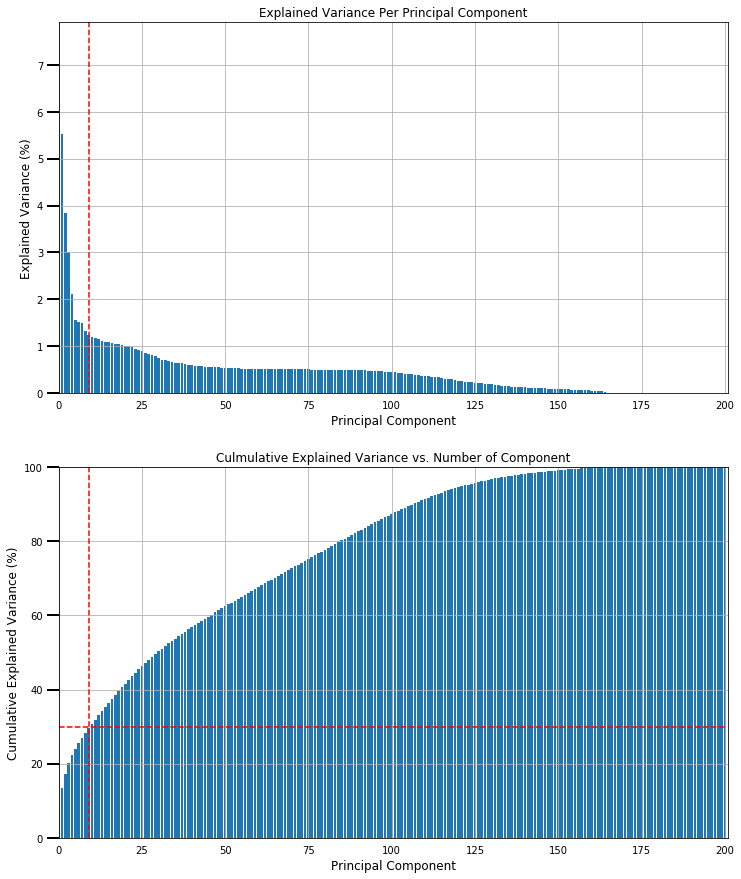

In [41]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca, var_thres = 30)

In [42]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components = 10 
pca = PCA(n_components = n_components)
azdias_scaled_pca = pca.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?) <br>
<strong>Reviewer's Comment:</strong>

*Good job plotting two very nicely done plots to visualize the variance explained by each principal component!*

*However, to meet the specification here, the principal component cutoff you chose should be justified by a turning point or drop off in variance explained. 120 components is on the high side, considering the total is 199 features and more than 60% of the variance can be explained by just around 50 components. The general idea is to select a stopping point where additional features do not add much to the amount of variability in the data that is explained. The total amount of variability is not the most important deciding factor here.*

<strong>Changes in response to suggestion below:</strong><br>
<strong>Answer</strong>: The scree plot shows that explained variance drops significantly around 10-th principal component, followed by a flat decaying tail afterward. At this sharp drop-off, the corresponding culmulative explained variance consists of 30% of total variance, as shown in the second plot. This could be considered as a good stopping point where additonal components do not contribute much to the explained variance. Based on above justifications, 10 principal components will be retained in the following analysis.



### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

The first principal component to corresponding feature names, sorted by the weight: 


,Dimension,feature,PCA_Weight
0,Dimension 1,LP_STATUS_GROB_1.0,0.1924
1,Dimension 1,MOBI_REGIO,-0.1843
2,Dimension 1,FINANZ_MINIMALIST,-0.1837
3,Dimension 1,HH_EINKOMMEN_SCORE,0.1831
4,Dimension 1,WEALTH,0.1822
5,Dimension 1,PLZ8_ANTG1,-0.1820
6,Dimension 1,PLZ8_ANTG3,0.1802
7,Dimension 1,KBA05_GBZ,-0.1780
8,Dimension 1,KBA05_ANTG1,-0.1772
9,Dimension 1,PLZ8_ANTG4,0.1751


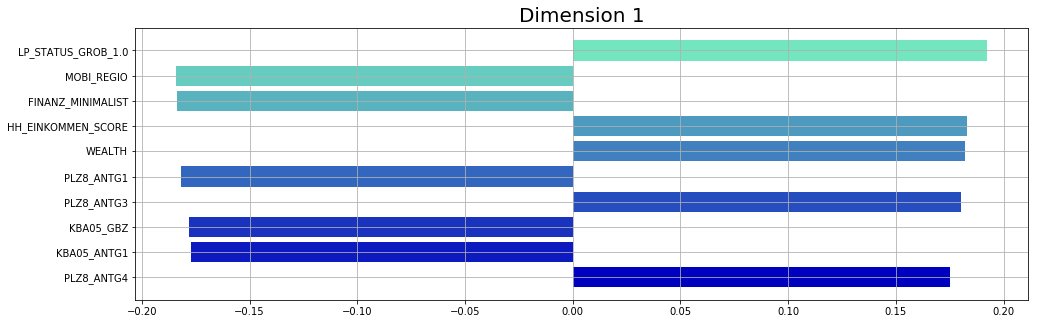

In [43]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# summarize the weights of each feature in all pca components
pca_weights = pca_weight_decomp(df_scaled, pca)
# show and save the top k features, sorted by their PCA weights in descending order
dim1 = show_pca_weight(pca_weights, topk_components = 4, topk_features = 10, \
                            kth_component = 1, figsize = (16,5), plot = True, print_screen = False)
print("The first principal component to corresponding feature names, sorted by the weight: ")
display(dim1)

The second principal component to corresponding feature names, sorted by the weight: 


,Dimension,feature,PCA_Weight
10,Dimension 2,ALTERSKATEGORIE_GROB,0.2345
11,Dimension 2,DECADE,-0.2316
12,Dimension 2,FINANZ_SPARER,-0.2297
13,Dimension 2,FINANZ_VORSORGER,0.2200
14,Dimension 2,SEMIO_REL,-0.2196
15,Dimension 2,FINANZ_UNAUFFAELLIGER,-0.2158
16,Dimension 2,SEMIO_TRADV,-0.2089
17,Dimension 2,SEMIO_PFLICHT,-0.2073
18,Dimension 2,FINANZ_ANLEGER,-0.2024
19,Dimension 2,ZABEOTYP_3,0.2001


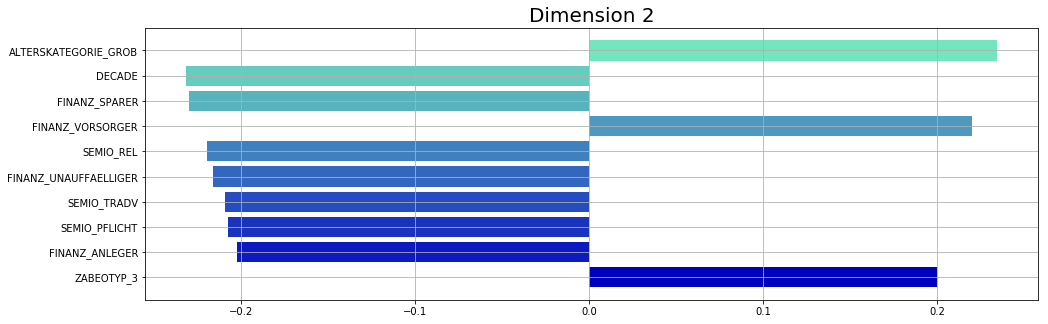

In [44]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
dim2 = show_pca_weight(pca_weights, topk_components = 4, topk_features = 10, \
                            kth_component = 2, figsize = (16,5), plot = True, print_screen = False)
print("The second principal component to corresponding feature names, sorted by the weight: ")
display(dim2)


The third principal component to corresponding feature names, sorted by the weight: 


,Dimension,feature,PCA_Weight
20,Dimension 3,ANREDE_KZ_1,0.3274
21,Dimension 3,ANREDE_KZ_2,-0.3274
22,Dimension 3,SEMIO_VERT,0.3001
23,Dimension 3,SEMIO_KAEM,-0.2946
24,Dimension 3,SEMIO_DOM,-0.2631
25,Dimension 3,SEMIO_KRIT,-0.2470
26,Dimension 3,SEMIO_FAM,0.2392
27,Dimension 3,SEMIO_SOZ,0.2381
28,Dimension 3,SEMIO_KULT,0.2311
29,Dimension 3,SEMIO_ERL,-0.1881


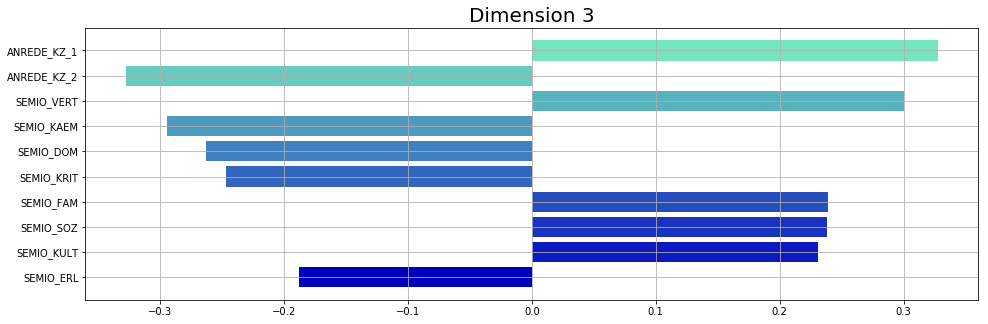

In [45]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
dim3 = show_pca_weight(pca_weights, topk_components = 4, topk_features = 10, \
                            kth_component = 3, figsize = (16,5), plot = True, print_screen = False)
print("The third principal component to corresponding feature names, sorted by the weight: ")
display(dim3)


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

<strong>Answer</strong>: Yes, the results from above clearly indicate feature association with the pricipal components. Below are more detailed interpretation. 

For the first principal component, it is likely to group features related to financial and social status. The positive weights indicate lower income, and social status. For instance, the dummy variable <strong>LP_STATUS_GROB_1.0</strong> = 1 indicates a positive direction towards lower income earners (as shown by the data dictionary). And the same is true in the case of <strong>HH_EINKOMMEN_SCORE</strong>, with a higher score indicating lower household income. Another features showing a negative weight is the <strong>FINANZ_MINIMALIST</strong>, with higher value indicating lower financial interest (meaning better financial credit). 

The second principal component binds elderly-related features together. For example, <strong>ALTERSKATEGORIE_GROB</strong> is the age postulated from the person's name, which weights in the positive direction, with a higher value indicating an elder age. In contrast, <strong>SEMIO_TRADV</strong> shows a negative weight. It can interpreted from the dictionary that a higher score indicating less tradional-minded, and therefore younger age.

Finally, the third component is related to the gender, as supported by the positive feature <strong>ANREDE_KZ_1</strong> (male) and the negative feature <strong>ANREDE_KZ_2</strong> (female). Some other features related to the personality, such as <strong>SEMIO_DOM</strong> (dominant-minded), <strong>SEMIO_FAM</strong> (family-minded), and <strong>SEMIO_KAEM</strong> (combative attitude), are also indirect but very useful information to differentiate a men or women.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [46]:
# Over a number of different cluster counts...
# define helper function to train kmean model
def train_kmean(data, clusters, use_batch = True, batch_portion = 0.2, print_every = 5):
    '''
        clusters: the number of clusters used to fit the data
        use_batch: if true, will use mini-batch kmean
        batch_portion: the portion of batch size
        return: list of number of kmean clusters, and the corresponding scores
    '''
    centers = []
    scores = []
    batch_size = int(data.shape[0]*batch_portion)
    print("Input data dimension: ", data.shape)
    if use_batch:
        print("Using minibatch Kmean.")
    else:
        print("Using Kmean.")
    for i, n_clusters in enumerate(clusters):
        # run k-means clustering on the data and...
        if use_batch:
            km = MiniBatchKMeans(n_clusters = n_clusters, batch_size = batch_size)
        else:
            km = KMeans(n_clusters = n_clusters)
        model = km.fit(data) 
        # compute the average within-cluster distances.
        score = np.abs(model.score(data))
        centers.append(n_clusters)
        scores.append(score)
        if i % print_every == 0:
            print("The score for {} clusters is {} ".format(n_clusters, score))
    return centers, scores


In [47]:
clusters = np.arange(1, 35)
centers, scores = train_kmean(azdias_scaled_pca, clusters, batch_portion = 0.1, use_batch = True)

Input data dimension:  (797837, 10)
Using minibatch Kmean.
The score for 1 clusters is 47348209.760469936 
The score for 6 clusters is 26769078.440056246 
The score for 11 clusters is 22315337.135041233 
The score for 16 clusters is 19798832.282240726 
The score for 21 clusters is 17962299.508996155 
The score for 26 clusters is 16888097.225297954 
The score for 31 clusters is 15944105.569156157 


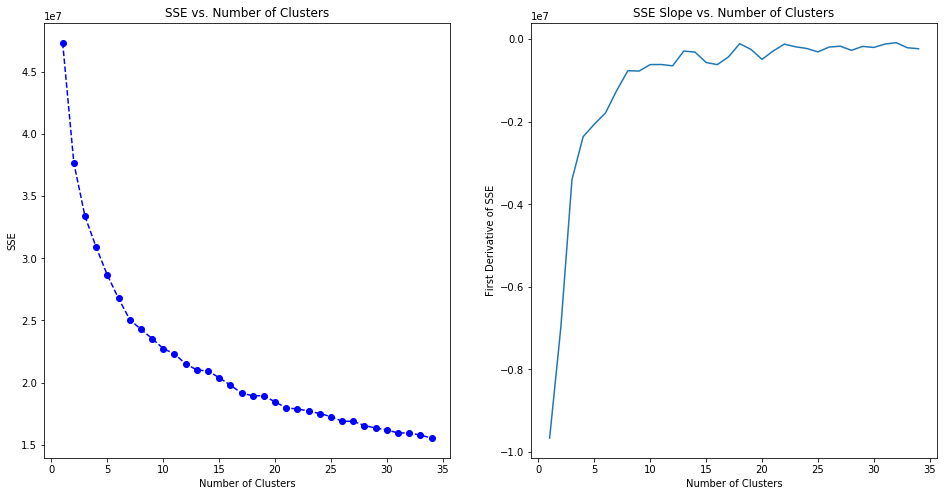

In [48]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
def plot_kmean_score(centers, scores):       
    fig = plt.figure(figsize = (16, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    plt.plot(centers, scores, linestyle='--', marker='o', color='b')
    plt.xlabel('Number of Clusters')
    plt.ylabel('SSE')
    plt.title('SSE vs. Number of Clusters')
    ax2 = fig.add_subplot(1, 2, 2)
    plt.plot(centers, np.gradient(scores))
    plt.xlabel('Number of Clusters')
    plt.ylabel('First Derivative of SSE')
    plt.title('SSE Slope vs. Number of Clusters')
    
plot_kmean_score(centers, scores)

In [49]:
n_clusters = 15
km = KMeans(n_clusters = n_clusters)
model = km.fit(azdias_scaled_pca)
# convert ndarray to dataframe object
azdias_label = pd.DataFrame({"Cluster_ID": model.predict(azdias_scaled_pca)})

df_azdias_scaled_pca = pd.DataFrame(data = azdias_scaled_pca, \
        columns = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)])
df_azdias_scaled_pca = pd.concat([df_azdias_scaled_pca, azdias_label], axis=1)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

<strong>Answer</strong>: I picked 15 clusters to segment the population. The scree plot on the left panel above shows that the average distance (SSE) decreases with the number of clusters monotonically. To find the elbow at which decreasing in the distance is not substantial enough to suggest the need for an additional cluster, I calculated their first derivative (the slope) with respect to the number of clusters, as shown in the right panel. With increased clusters, the slope starts to stablize around 11-15 clusters. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [50]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [51]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_processed = clean_data(customers, col_thres = None)
customers_NaN_CNT = customers.shape[0] - customers_processed.shape[0]
'''
The customer dataset missed a value of 5 in GEBAEUDETYP feature. 
Therefore, when converted to dummy variable, we need to add a column GEBAEUDETYP_5.0 with all zeros.
Noted that this column shall be added in place as the dataframe will be converted into a matrix.
'''
col_pos = 135
# diff = [x for x in azdias_processed.columns if x not in customers_processed.columns]
# customers_processed.columns[121:150]
customers_processed.insert(col_pos, "GEBAEUDETYP_5.0", np.zeros(customers_processed.shape[0]))
# apply feature scaling using the fitted scaler
customers_scaled = scaler.transform(customers_processed)
# convert from ndarray to dataframe object
df_customers = pd.DataFrame(data=customers_scaled, index=customers_processed.index, columns=customers_processed.columns)
print("The dataset's dimension after standard scaling: {}, \n".format(customers_scaled.shape))
# apply PCA transformation
customers_scaled_pca = pca.transform(customers_scaled)
# predict the customer cluster using the fitted model
customers_label = pd.DataFrame({"Cluster_ID": model.predict(customers_scaled_pca)})
# convert ndarray to dataframe object
df_customers_scaled_pca = pd.DataFrame(data = customers_scaled_pca, \
                                    columns = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)])
df_customers_scaled_pca = pd.concat([df_customers_scaled_pca, customers_label], axis=1)


 Step 1: drop the following features with high NaN occupancy rate above None%: 
 ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']

 6 features have been dropped. The new dataset dimension after Step 1 is: (191652, 79)

 Step 2: drop rows with high NaN occupancy rate above 30%... 


 49962 of rows have been dropped. The new dataset dimension after Step 2 is: (141690, 79)

 After step 2, there are 26047 rows left with missing values, consisting of 18.38308984402569% of the total population
Feature "KKK" has 7.133883830898441% missing values
Feature "REGIOTYP" has 7.133883830898441% missing values
Feature "LP_LEBENSPHASE_FEIN" has 6.9200366998376746% missing values
Feature "LP_LEBENSPHASE_GROB" has 6.8445197261627495% missing values
Feature "LP_FAMILIE_GROB" has 6.608088079610417% missing values
Feature "LP_FAMILIE_FEIN" has 6.608088079610417% missing values
Feature "W_KEIT_KIND_HH" has 5.59037335027172% missing values
Feature "KBA05_GBZ" has 4.24871197

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.35,1.02,'Note: Cluster 15 represents high-NaN data')

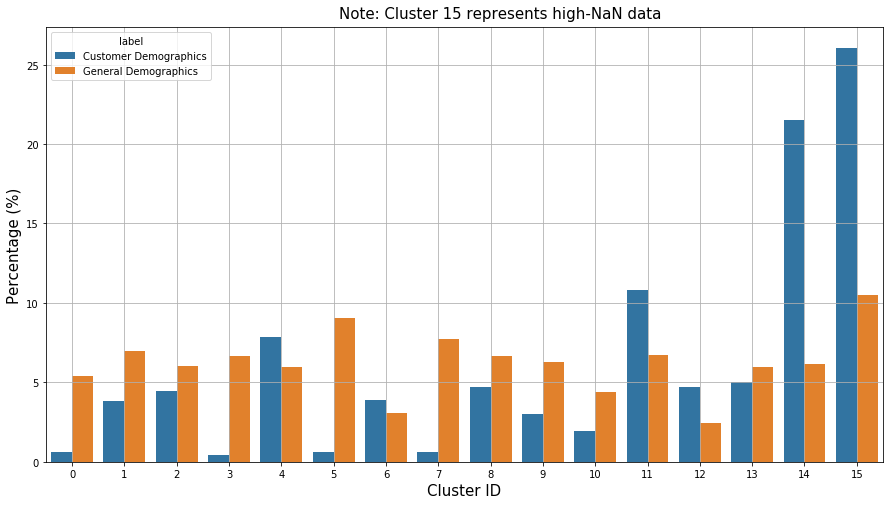

In [52]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

df_azdias_scaled_pca['label'] = 'General Demographics'
df_customers_scaled_pca['label'] = 'Customer Demographics'
pred_label = pd.concat([df_azdias_scaled_pca, df_customers_scaled_pca])

# some trivial calculations below
plot_data = pred_label.groupby(['label'])['Cluster_ID'].value_counts().astype(float).rename("Count")
plot_data = pd.DataFrame(plot_data)
plot_data.reset_index(inplace=True)
# assign the large-Nan data to a new cluster
ls = [['Customer Demographics', n_clusters, customers_NaN_CNT], ['General Demographics', n_clusters, azdias_NaN_CNT]]
for i, (label, cluster_id, CNT) in enumerate(ls):
    new_cluster = pd.Series({'label':label,'Cluster_ID': cluster_id,'Count': CNT})
    plot_data = plot_data.append(new_cluster, ignore_index=True)
# total number of counts in population and customer dataset, including the large-NaN data
sum0 = plot_data[plot_data.label == 'Customer Demographics'].Count.sum(axis = 0)
sum1 = plot_data[plot_data.label == 'General Demographics'].Count.sum(axis = 0)
# calculate the percentage distribution  
plot_data['Percentage'] = np.where(plot_data['label']=='Customer Demographics', plot_data['Count']/sum0*100, plot_data['Count']/sum1*100)

fig = plt.figure(figsize = (15,8))
ax = sns.barplot(x='Cluster_ID', y="Percentage", hue='label', data=plot_data)
ax.set_xlabel("Cluster ID", fontsize = 15)
ax.set_ylabel("Percentage (%)", fontsize = 15)
#ax.set_title(column, fontsize = 20)
ax.grid()
plt.annotate("Note: Cluster {} represents high-NaN data".format(n_clusters), \
        xy=(0.35, 1.02), xycoords='axes fraction', fontsize = 15)

In [54]:
# What kinds of people are part of a cluster that is overrepresented/underrepresented in the
# customer data compared to the general population?

# select one overrepresenting cluster, and one underrepresenting cluster
centroid_id = [14, 5]
centroids = []
cluster_center = km.cluster_centers_[centroid_id,:]
df_result = pd.DataFrame(data = scaler.inverse_transform(pca.inverse_transform(cluster_center)), \
    columns = azdias_processed.columns, index = ['Cluster 14 (overrepresenting)', 'Cluster 5 (underrepresenting)'])
# income-related features
income_col = ['HH_EINKOMMEN_SCORE','LP_STATUS_GROB_1.0','LP_STATUS_GROB_2.0',\
            'LP_STATUS_GROB_3.0','LP_STATUS_GROB_4.0','LP_STATUS_GROB_5.0',\
            'FINANZ_MINIMALIST', 'WEALTH']
# age-related features
age_col = ['ALTERSKATEGORIE_GROB', 'DECADE']
# gender-related features
gender_col = ['ANREDE_KZ_1','ANREDE_KZ_2']
# movement features
move_col = ['GREEN_AVANTGARDE_0','GREEN_AVANTGARDE_1', 'MOVEMENT']
# building location
location_col = ['OST_WEST_KZ_O','OST_WEST_KZ_W']

features = income_col + age_col + gender_col + move_col + location_col

parents = ['Income' for i in np.arange(len(income_col))] + \
        ['Age' for i in np.arange(len(age_col))] + \
        ['Gender' for i in np.arange(len(gender_col))] + \
        ['Movement' for i in np.arange(len(move_col))] + \
        ['Apartment Location' for i in np.arange(len(location_col))]

meaning = ['Estimated household net income', 'low-income earners', 'average earners', \
           'independents', 'houseowners', 'top earners', 'low financial interest', 'Wealth Scale',\
          'Estimated age', 'Borned Decades', 'Male', 'Female', \
           'mainstream', 'avantgarde', 'mainstream vs. avantgarde', 'East Germany', 'West Germany']
df_summary = pd.DataFrame(df_result[features].T.values, \
                  index=[parents, features, meaning], columns = df_result.index)

display(df_summary)

Cluster 14 (overrepresenting)  \
Income             HH_EINKOMMEN_SCORE   Estimated household net income                       2.176742   
                   LP_STATUS_GROB_1.0   low-income earners                                  -0.008283   
                   LP_STATUS_GROB_2.0   average earners                                      0.084760   
                   LP_STATUS_GROB_3.0   independents                                         0.031518   
                   LP_STATUS_GROB_4.0   houseowners                                          0.127677   
                   LP_STATUS_GROB_5.0   top earners                                          0.764329   
                   FINANZ_MINIMALIST    low financial interest                               4.769266   
                   WEALTH               Wealth Scale                                         1.792863   
Age                ALTERSKATEGORIE_GROB Estimated age                                        3.054255   
                   DECADE               Borned Decades                                       3.801729   
Gender             ANREDE_KZ_1          Male                                                 0.946148   
                   ANREDE_KZ_2          Female                                               0.053852   
Movement           GREEN_AVANTGARDE_0   mainstream                                           0.029329   
                   GREEN_AVANTGARDE_1   avantgarde                                           0.970671   
                   MOVEMENT             mainstream vs. avantgarde                            0.970671   
Apartment Location OST_WEST_KZ_O        East Germany                                         0.083026   
                   OST_WEST_KZ_W        West Germany                                         0.916974   

                                                                        Cluster 5 (underrepresenting)  
Income             HH_EINKOMMEN_SCORE   Estimated household net income                       5.681588  
                   LP_STATUS_GROB_1.0   low-income earners                                   0.957994  
                   LP_STATUS_GROB_2.0   average earners                                      0.130430  
                   LP_STATUS_GROB_3.0   independents                                        -0.018763  
                   LP_STATUS_GROB_4.0   houseowners                                         -0.068665  
                   LP_STATUS_GROB_5.0   top earners                                         -0.000996  
                   FINANZ_MINIMALIST    low financial interest                               1.015736  
                   WEALTH               Wealth Scale                                         4.379137  
Age                ALTERSKATEGORIE_GROB Estimated age                                        1.816171  
                   DECADE               Borned Decades                                       5.854566  
Gender             ANREDE_KZ_1          Male                                                 0.016220  
                   ANREDE_KZ_2          Female                                               0.983780  
Movement           GREEN_AVANTGARDE_0   mainstream                                           0.966531  
                   GREEN_AVANTGARDE_1   avantgarde                                           0.033469  
                   MOVEMENT             mainstream vs. avantgarde                            0.033469  
Apartment Location OST_WEST_KZ_O        East Germany                                         0.283579  
                   OST_WEST_KZ_W        West Germany                                         0.716421

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

<strong>Answer</strong>: The countplot above clearly shows that the customers in Cluster 14 overrepresents the general population (22% vs. 6%), suggesting the general population in this cluster shall be targeted as highly-potential customers. On the other hand, the customers in Cluster 5 shows the oppositve trend, an underrepresentation of the general demongraphics (around 1% vs 9%). Therefore, this market segment of general population is of our least interest, since customers of this kind are unlikely to place mailed order. Note that Cluster 15 is mannualy added to represent the group of data with lots of missing values. The customer dataset contains more than 25% high-NaN data of its total population. 

By projecting the fitted Kmean-centroids back to the original feature space, I compared several features of the two clusters of people, based on their income level, age, gender, movement, and living location, as shown by the table above. To interpret this table, for Cluster 14 (overrepresenting) as an example, the first row <strong>HH_EINKOMMEN_SCORE</strong> scales the estimated household net income from 1 to 6, with higher scores indicating lower income. Cluster 11 has a value of 2.18, falling into the range betwen "very high income" and "high income" according to the data dictionary. The <strong>LP_STATUS_GROB_X.0</strong> are dummy variables converted from <strong>LP_STATUS_GROB</strong>, a rough scale on the social status. Here, Cluster 11 are heavily weighted on the LP_STATUS_GROB_5.0 bucket (76.4%), corresponds to "top earners" in the dictionary, which is consistent with <strong>HH_EINKOMMEN_SCORE</strong>.


Based on the characteristics of above features, we can conclude that the most overrepresenting cluster is the group of people, with high-income in their middle-age borned in 40-50s, involved in green avantgarde, and mostly living in the area of former West Germany. People in the underrepresenting cluster trend to be on the opposite side: they are lower income earners, mainly younger female borned in the 80-90s, and not a member of green avantgarde.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.